<a href="https://colab.research.google.com/github/ThanmaiJami/ThanmaiJami/blob/main/Project_Phase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Colouring Old Black & White Images**

Manual colorization of black and white images is a laborious task and inadequate.
Photoshop editing is complex as it requires extensive research, and a picture can take up
to one month to colorize. A sensible approach to the task is to implement refined image
colorization techniques. The literature on image colorization has been an area of interest
in the last decade, as it stands at the convergence of two enigmatic disciplines, digital
image processing, and deep learning. We use the ever-increasing accessibility of
end-to-end deep learning models and leverage the benefits of transfer learning. The
training data can automatically extract image features using deep learning models such
as Convolutional Neural Networks (CNN). We can also expedite the exactness of the
image by human intervention and using recently developed Generative Adversarial
Networks (GAN).

### **1. Downloading and Processing the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#3000 images are used to train the model

In [ ]:
!unzip /content/drive/MyDrive/Project_dataset/data.zip

Archive:  /content/drive/MyDrive/Project_dataset/data.zip
  inflating: data/20056.jpg          
  inflating: data/20057.jpg          
  inflating: data/20058.jpg          
  inflating: data/20059.jpg          
  inflating: data/20060.jpg          
  inflating: data/20061.jpg          
  inflating: data/20062.jpg          
  inflating: data/20064.jpg          
  inflating: data/20066.jpg          
  inflating: data/20067.jpg          
  inflating: data/20068.jpg          
  inflating: data/20069.jpg          
  inflating: data/20070.jpg          
  inflating: data/20071.jpg          
  inflating: data/20072.jpg          
  inflating: data/20073.jpg          
  inflating: data/20074.jpg          
  inflating: data/20075.jpg          
  inflating: data/20076.jpg          
  inflating: data/20077.jpg          
  inflating: data/20078.jpg          
  inflating: data/20079.jpg          
  inflating: data/20080.jpg          
  inflating: data/20081.jpg          
  inflating: data/20082.jpg   

### **2. Importing Libraries**

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils.vis_utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
from tensorflow import keras

Calling tf.config.run_functions_eagerly(True) will make all invocations of tf.function run eagerly instead of running as a traced graph function.

This can be useful for debugging.

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
#batch size we use for training
batch_size = 64
#size of image required to train the model
img_size = 120
#number of images will be used from the data archive
dataset_split = 2500

In [ ]:
master_dir = "data"
x = []
y = []
for image_file in os.listdir(master_dir)[0 : dataset_split]:
  rgb_img = Image.open(os.path.join(master_dir, image_file)).resize((img_size, img_size))
  #normalize the rgb image array
  rgb_img_arr = (np.asarray(rgb_img))/255

  gray_img = rgb_img.convert('L')
  #normalize the grayscale image array
  gray_img_arr = (np.asarray(gray_img).reshape((img_size, img_size, 1)))/255
  
  #append both image arrays
  x.append(gray_img_arr)
  y.append(rgb_img_arr)

In [ ]:
#train-test splitting
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size = 0.1)

#construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)

## **GAN**

### **3. Generator**

In [ ]:
def get_generator_model():
  inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

  conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
  conv1 = tf.keras.layers.LeakyReLU()( conv1 )
  conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
  conv1 = tf.keras.layers.LeakyReLU()( conv1 )
  conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
  conv1 = tf.keras.layers.LeakyReLU()( conv1 )

  conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
  conv2 = tf.keras.layers.LeakyReLU()( conv2 )
  conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
  conv2 = tf.keras.layers.LeakyReLU()( conv2 )
  conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
  conv2 = tf.keras.layers.LeakyReLU()( conv2 )

  conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
  conv3 = tf.keras.layers.LeakyReLU()( conv3 )
  conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
  conv3 = tf.keras.layers.LeakyReLU()( conv3 )
  conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
  conv3 = tf.keras.layers.LeakyReLU()( conv3 )

  bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

  concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
  conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
  conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
  conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

  concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
  conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
  conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
  conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

  concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
  conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
  conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
  conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )
  
  model = tf.keras.models.Model( inputs , conv_up_1 )
  return model

### **4. Discriminator**

In [ ]:
def get_discriminator_model():
  layers = [
      tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
      tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
      tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
      tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
      tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense( 512, activation='relu'  ),
      tf.keras.layers.Dense( 128 , activation='relu' ),
      tf.keras.layers.Dense( 16 , activation='relu' ),
      tf.keras.layers.Dense( 1 , activation='sigmoid' )
      ]
  model = tf.keras.models.Sequential( layers )
  return model

### **5. Loss Function**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform(shape = real_output.shape, maxval = 0.1), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform(shape = fake_output.shape, maxval = 0.1), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output, real_y):
  real_y = tf.cast(real_y, 'float32')
  return mse(fake_output, real_y)

generator_optimizer = tf.keras.optimizers.Adam(0.0005)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

generator = get_generator_model()
discriminator = get_discriminator_model()

### **6. Training the GAN**

In [ ]:
@tf.function
def train_step(input_x, real_y):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #generate an image -> G(x)
    generated_images = generator(input_x, training = True)
    #probability that the given image is real -> D(x)
    real_output = discriminator(real_y, training = True)
    #probability that the given image is the one generated -> D(G(x))
    generated_output = discriminator(generated_images, training = True)

    #L2 Loss -> || y - G(x) ||^2
    gen_loss = generator_loss(generated_images, real_y)
    disc_loss = discriminator_loss(real_output, generated_output)

    #losses["D"].append(disc_loss.numpy())
    #losses["G"].append(gen_loss.numpy())

  #tf.keras.backend.print_tensor(tf.keras.backend.mean(gen_loss))
  #tf.keras.backend.print_tensor(gen_loss + disc_loss)

  #compute the gradients
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #optimize with ADAM
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

"""
generator.compile(
    optimizer = discriminator_optimizer,
    loss = discriminator_loss,
    metrics = ['accuracy']
)"""

"\ngenerator.compile(\n    optimizer = discriminator_optimizer,\n    loss = discriminator_loss,\n    metrics = ['accuracy']\n)"

### **6. Visualising Generator model**

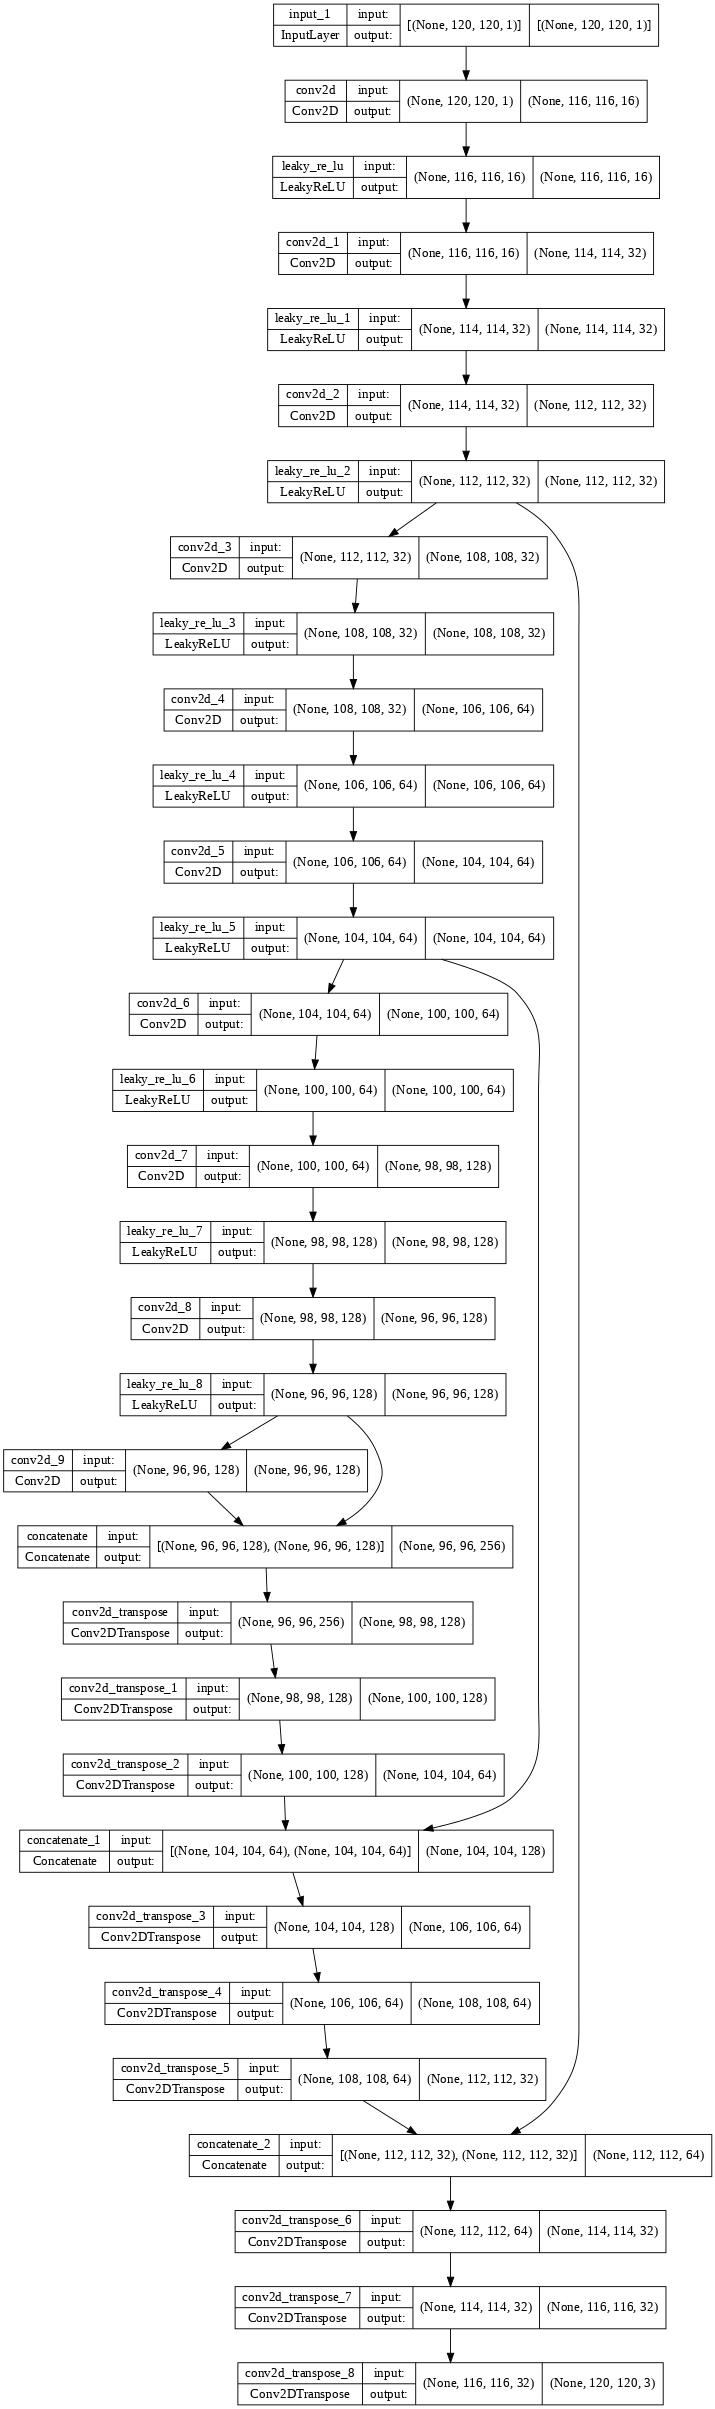

In [ ]:
plot_model(generator, to_file = 'generator.png', show_shapes = True, show_layer_names = True, dpi = 66)

In [ ]:
epochs = 3
losses = {"D" : [], "G" : []}
for i in range(epochs):
  print("Running epoch : ",i)
  for (x,y) in dataset:
    #Here (x,y) represents a batch from our training dataset
    print(x.shape)
    train_step(x,y)

Running epoch :  0
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(10, 120, 120, 1)
Running epoch :  1
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120

### **7. Results**

In [ ]:
y = generator(test_x[0 : ]).numpy()#took 2 minutes to execute this part of code

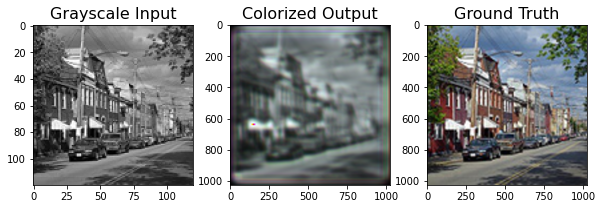

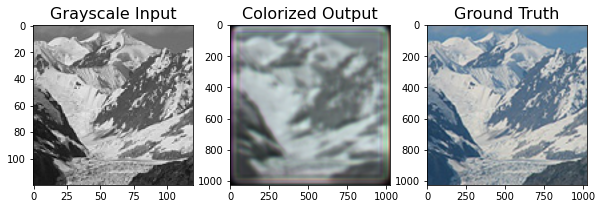

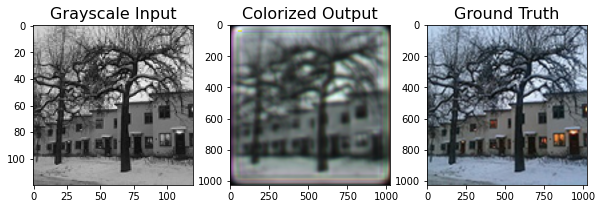

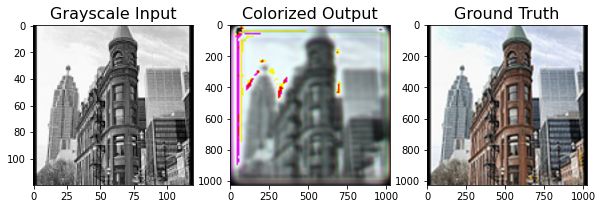

In [ ]:
for i in range(11, 33, 7):
  plt.figure(figsize = (10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )
  in_image = plt.subplot(3,3,2)
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )
  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )
  plt.show()

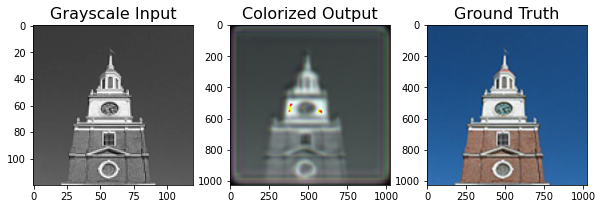

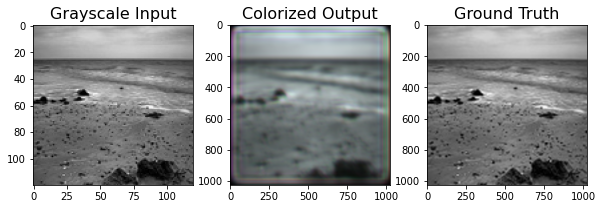

In [ ]:
for i in range(len(test_x)):
  plt.figure(figsize = (10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((120,120)) , cmap='gray' )
  
  in_image = plt.subplot(3,3,2)
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )
  plt.show()